In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import required libraries
from skimage.measure import label
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy as sp
from scipy import signal
import bruges as bg
import seismic.additional_functions as seis # library created for the purpose of this lecture series, explore further if interested!

## Practical 1: Synthetic Seismic

In this exercise you will explore how geological features appear in seismic reflection data and how their appearance differs with density, P-wave velocity, wavelet phase and frequency. You will also investigate how seismic reflection images will degrade with depth. 

In this exercise you are simulating a "zero-offset" seismic experiment where sources and receivers are located at the same place just below the Earth's surface so you are only dealing with "normal-incidence" reflections. 

As you move through the exercise there will be questions to think about and discussion with your peers is encouraged. 

**If you have time see [Bonus](./Ex1_Bonus.ipynb) excercise.**

**Learning objectives**:
1) understand that seismic reflection profiles are produced by the convolution of wavelets reflected from different geological boundaries
2) Understand how reflection coefficients and velocity control the amplitude and depth of reflection in seismic profiles
3) Understand seismic vertical resolution and the limitations of the seismic reflection method

## 1.1 Creating a synthetic geological model 
We can either read an seismic image for the deolohical model or use ['bruges'](https://code.agilescientific.com/bruges/) library to create one. Here we are using burges library to create a 5 geological section. (you can see [Extra](./Ex1_Extra.ipynb) for the first approach.

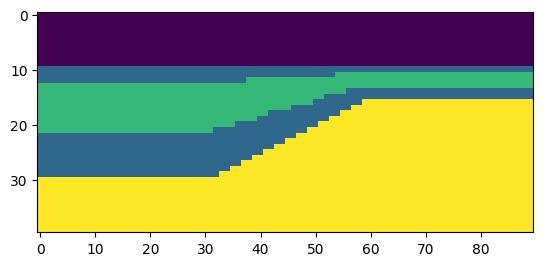

In [11]:
# Building the geological model:
model, *_ = bg.models.wedge(depth=(10, 20, 10),                     #y-axis
                            width=(30, 30, 30),                    #x-axis
                            strat=(0, (1, 2, 2, 2, 1, 1, 1,),3),    #geological units
                            thickness=(1, .3),                       #slope
                            mode='linear',                          #try: sigmoid, power, root
                            conformance='none'                      #try: top, base, 
                           )

plt.imshow(model)
plt.show()

## 1.2 P-wave Velocity and Density


In [5]:
# Assigning the petrophysical properties for each geological unit [density * velocity]:
rocks = np.array([1.62 * 2.00,       #geological units index 0
                  1.84 * 2.60,       #geological units index 1
                  2.90 * 5.00,       #geological units index 2
                  2.30 * 3.92        #geological units index 3
                 ])

## 1.3. Acoustic impedance

In [6]:
# Calculating the acoustic impedance for each geological unit:
impedance = rocks[model]

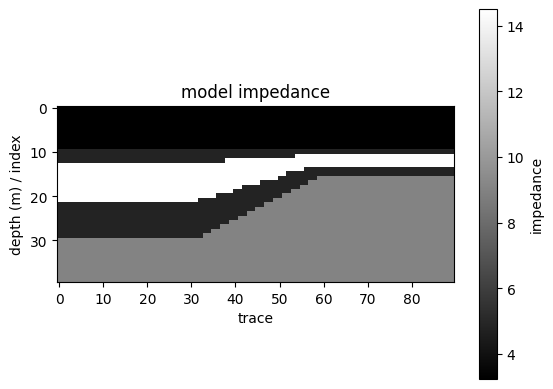

In [9]:
plt.imshow(impedance, cmap='gray', aspect=1)
plt.title('model impedance')
plt.ylabel('depth (m) / index')
plt.xlabel('trace')
plt.colorbar(label = 'impedance')
plt.show()

**Note: If you do not understand the code above please see [numpy 3d array](https://stackoverflow.com/questions/22981845/3-dimensional-array-in-numpy) and [along_axis](https://stackoverflow.com/questions/9019581/what-does-numpy-apply-along-axis-perform-exactly) guidance. 

#### Excersice 1 : We have the materials as bellow in the sections: section 1: dry sand, section 2: Sandstones, section 3: Limestones, and section 4: Granite. calculate the calculate acoustic impedance.

**Hint: To see the velocity of each layer you can use table 3.1 Kearey, Brooks & Hill. An introduction to Geophysical Exploratio and to calculate density you can use Gardner relationship ($ \rho = 0.31 V_p ^ {0.25} $) from the lecture.


In [12]:
## please write your code here
# velocities = 
#Gardner_relation = 
# Densities = 
# rocks_2 = 
#impedance_2 = 

## 1.4 Reflection coefficients
For "zero-offset" surveys where sources and receivers are located at the same place we only need to worry about "normal incidence reflections". Therefore, we can use the equation: $$ \text{ Reflection coefficient } = \frac{\rho_2 V_2 - \rho_1 V_1 }{\rho_2 V_2 + \rho_1 V_1} $$


In [15]:
# Calculating the reflectivity at the geological units interface:

rc = (impedance[1:] - impedance[:-1]) / (impedance[1:] + impedance[:-1])
rc

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Visualization
we have derived a variety of physical relationships. Let's visualise a vertical profile through the model 1 of acoustic impedance and reflection coefficients to compare them for each model. 

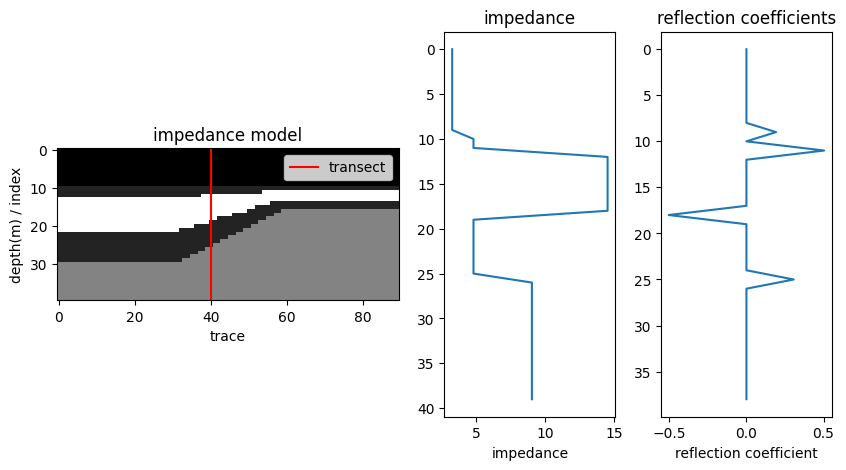

In [115]:
trace = np.shape(impedance)[1] - 50 # Try to change the trace place

fig, ax = plt.subplots(1,3, figsize=(10, 5),gridspec_kw={'width_ratios': (4, 2, 2)})

ax[0].imshow(impedance, cmap='gray')
ax[0].axvline(trace, c = 'r', label ='transect')
ax[0].set(title = 'impedance model', ylabel='depth(m) / index', xlabel = 'trace')
ax[0].legend()

ax[1].plot(impedance[:,trace],  np.arange(len(impedance)))
ax[1].set (title = 'impedance', xlabel = 'impedance')
ax[1].invert_yaxis()

ax[2].plot(rc[:,trace], np.arange(len(rc)))
ax[2].set (title = 'reflection coefficients', xlabel = 'reflection coefficient')
ax[2].invert_yaxis()
plt.show()

#### Excersice2: Calculate reflection coefficients for model 2 and visualize rc and impedance alongside with your model.

**Hint: output should be a 2D array containing the reflection coefficients. 

In [14]:
#rc_2 = 

## 1.5 Wavelet frequency and Convolution to produce 2D synthetic seismic section


When we aquire and process seismic data we would like the source wavelet to be as close as possible to a spike function. In this part of the excercise we will explore the reasons for that.

In this section we will use a wavelet funcyion of bruges library. For the other 2 ways of creating Ricker wavelet see [Bonus](./Ex1_Bonus.ipynb) excercise.

### Ricker wavelet

As we discussed in the lectures,  The Ricker wavelet is “zero-phase”, it’s max amplitude occurs at t=0. It is impossible to create during acquisition, but we can convert a minimum-phase input wavelet into a Ricker wavelet during seismic processing
some further reading: https://academic.oup.com/gji/article/200/1/111/746485

<div class="alert alert-info"><h3>To create a Ricker wavelet you can write down your own function (see the bonus exersice), or use :</h3>
<tt><a href='https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.signal.ricker.html'><strong>scipy.signal.ricker</strong></a><font color=black></font>&nbsp;&nbsp;</
 or:
    </h3>
<tt><a href='https://github.com/agilescientific/bruges'><strong>bruges.filters.ricker</strong></a><font color=black></font>&nbsp;&nbsp;</div>

In [139]:
# Wavelet generation:
ricker, t = bg.filters.ricker(duration=0.098, 
                              dt=0.002, 
                              f=50)
#plt.plot(ricker)

#klauder, _ = bg.filters.ricker(0.256, 0.002, [12, 48])
#ormsby, _ = bg.filters.ormsby(0.256, 0.002, [5, 10, 40, 80])


In [66]:
synth = np.apply_along_axis(np.convolve, arr=rc, axis=0, v=ricker, mode='same')


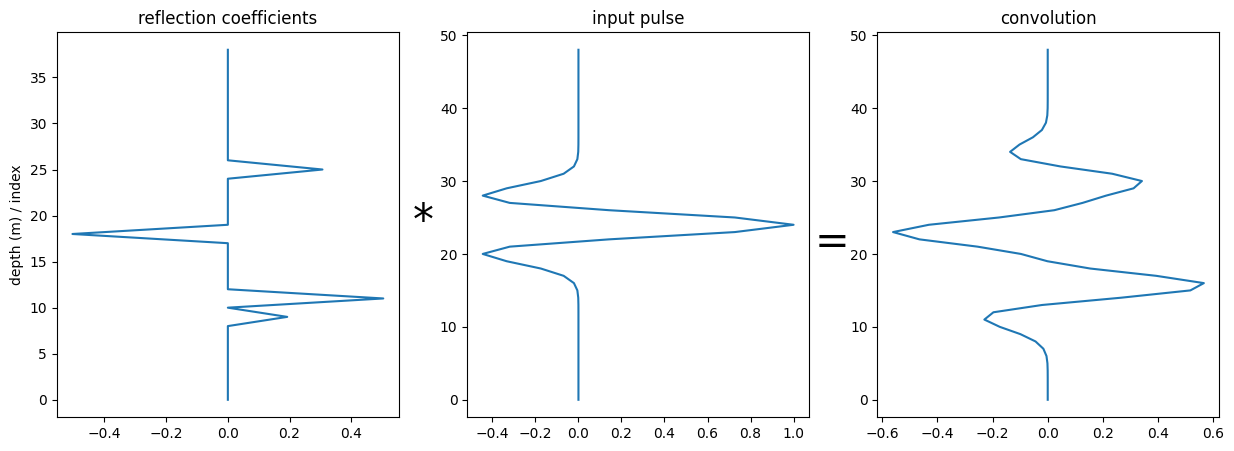

In [138]:
trace_1 = np.shape(impedance)[1]-50

fig, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].plot(rc[:,trace_1], np.arange(len(rc)))
ax[0].set (title = 'reflection coefficients', ylabel='depth (m) / index')
ax[1].plot(ricker, np.arange(len(ricker)))
ax[1].set (title = 'input pulse')
ax[2].plot(synth[:,trace_1], np.arange(len(synth)))
ax[2].set (title = 'convolution')
ax[0].text(.6, 18, '*', size=30)
ax[1].text(1.1, 20, '=', size=30)
plt.show()

### Try different frequencies and see how it affects

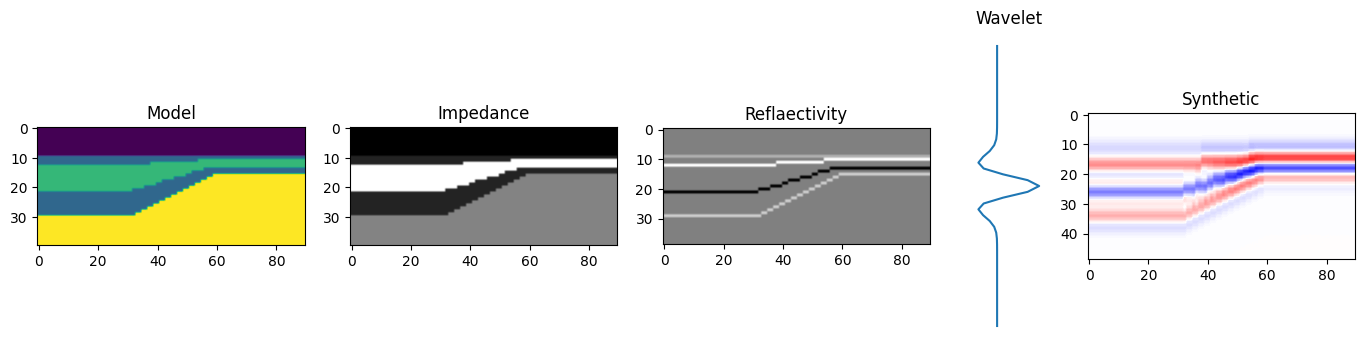

In [92]:
#Plot:

fig, axs = plt.subplots(figsize=(17, 4), ncols=5, gridspec_kw={'width_ratios': (4, 4, 4, 1, 4)})
axs[0].imshow(model)
axs[0].set_title('Model')
axs[1].imshow(impedance, cmap = 'gray')
axs[1].set_title('Impedance')
axs[2].imshow(rc, cmap = 'gray')
axs[2].set_title('Reflaectivity')
axs[3].plot(ricker, np.arange(ricker.size))
axs[3].axis('off')
axs[3].set_title('Wavelet')
axs[4].imshow(synth, cmap = 'seismic', vmin = -2, vmax = 2)
axs[4].set_title('Synthetic')
plt.show()

#### Excersice3: Try different frequency to see the changes in the resolution of sections. Explain your findings below.**


In [14]:
#ricker2, t = 

In [15]:
#synth2 = 

[Hint]
- providing a wider input wavelet will reduce the resolution of our model, we require higher smaller-wavelets (higher frequencies) to obtain better resolutions


#### Excersice4: Try different wavelet

In [ ]:
#klauder, _ = bg.filters.ricker(0.256, 0.002, [12, 48])
#ormsby, _ = bg.filters.ormsby(0.256, 0.002, [5, 10, 40, 80])


# 1.5 attenuation and noise
Note that so far we have created our data whereas in the real case at field the data is our input. In reality we would aim to take the inverse of this process to recover the original Earth Model. With our very simplified model above this is not very difficult however in reality, there are many factors that will affect the amplitude and frequency of reflections. Some of these affects can be corrected for during processing (e.g. spherical divergence) and some of them are unknown (e.g. absorption). 
In bonas excercise you can play with adding  Spherical divergence, Absorption, advanced, and Noise.
If you have time see [Bonus](./Ex1_Bonus.ipynb)